# Introduction to Bedrock - Building with Bedrock Embeddings

In this demo notebook, we demonstrate how to use the Bedrock Python SDK for Embeddings Generation.

1. [Set Up](#1.-Set-Up)
2. [Embeddings Generation](#2.-Embeddings-Generation)
3. [Semantic Similarity](#3.-Semantic-Similarity)

Note: This notebook was tested in Amazon SageMaker Studio with Python 3 (Data Science 2.0) kernel.

### 1. Set Up

---
Before executing the notebook for the first time, execute this cell to add bedrock extensions to the Python boto3 SDK

---

Let's initialize the boto3 client to use Bedrock

**Select region: "us-east-1"(M1), "us-west-2"(M2)**

In [2]:
bedrock_region = "us-west-2" 

In [8]:
if bedrock_region == "us-east-1":    
    bedrock_config = {
        "region_name":bedrock_region,
        "endpoint_url":"https://bedrock.us-east-1.amazonaws.com"
    }
elif bedrock_region == "us-west-2":  
    bedrock_config = {
        "region_name":bedrock_region,
        "endpoint_url":"https://prod.us-west-2.frontend.bedrock.aws.dev"
    }


In [9]:
import boto3
import json
bedrock = boto3.client(
    service_name='bedrock',
    region_name=bedrock_config["region_name"],
    endpoint_url=bedrock_config["endpoint_url"]
)

Lets test the endpoint to see what models are available

In [10]:
bedrock.list_foundation_models()

{'ResponseMetadata': {'RequestId': 'c6fc8d20-a554-4ced-b04e-dadaf565edd6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Fri, 14 Jul 2023 04:40:06 GMT',
   'content-type': 'application/json',
   'content-length': '861',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'c6fc8d20-a554-4ced-b04e-dadaf565edd6'},
  'RetryAttempts': 0},
 'modelSummaries': [{'modelArn': 'arn:aws:bedrock:us-west-2::foundation-model/amazon.titan-tg1-large',
   'modelId': 'amazon.titan-tg1-large'},
  {'modelArn': 'arn:aws:bedrock:us-west-2::foundation-model/amazon.titan-e1t-medium',
   'modelId': 'amazon.titan-e1t-medium'},
  {'modelArn': 'arn:aws:bedrock:us-west-2::foundation-model/stability.stable-diffusion-xl',
   'modelId': 'stability.stable-diffusion-xl'},
  {'modelArn': 'arn:aws:bedrock:us-west-2::foundation-model/ai21.j2-grande-instruct',
   'modelId': 'ai21.j2-grande-instruct'},
  {'modelArn': 'arn:aws:bedrock:us-west-2::foundation-model/ai21.j2-jumbo-instruct',
   'modelId': 'ai21.j2-jumbo-in

### 2. Embeddings Generation

Embeddings are a key concept in generative AI and machine learning in general. An embedding is a representation of an object (like a word, image, video, etc.) in a vector space. Typically, semantically similar objects will have embeddings that are close together in the vector space. These are very powerful for use-cases like semantic search, recommendations and Classifications.

In [11]:
# We will be using the Titan Embeddings Model to generate our Embeddings.

def get_embedding(body, modelId, accept, contentType):
    response = bedrock.invoke_model(
        body=body,
        modelId=modelId,
        accept=accept,
        contentType=contentType
    )
    response_body = json.loads(response.get('body').read())
    embedding = response_body.get('embedding')
    return embedding

body = json.dumps(
    {
        "inputText": "explain black holes to 8th graders"
    }
)
modelId = 'amazon.titan-e1t-medium'
accept = 'application/json'
contentType = 'application/json'

embedding = get_embedding(body, modelId, accept, contentType)
print(embedding)

[0.5625, 0.53515625, 0.046875, 0.18457031, 0.17382812, -0.0010681152, 0.33789062, -0.039794922, -0.20507812, -0.31640625, -0.38085938, 0.13574219, 0.36132812, -0.32421875, 0.087402344, 0.28515625, -0.07763672, -0.084472656, -0.546875, -0.5703125, -0.39648438, 0.4921875, -0.3984375, 0.20703125, -0.8203125, 0.07714844, -0.13476562, -0.515625, -0.43945312, 0.31054688, 0.05419922, 0.07373047, 0.18066406, -0.35742188, -0.011352539, 0.53125, -0.04296875, -0.5625, -0.34765625, -0.14257812, 0.68359375, -0.07373047, -0.13574219, -0.43945312, 0.31054688, 0.38867188, 0.21679688, 0.14160156, -0.103027344, -0.083496094, -0.29296875, -0.13183594, 0.13085938, 0.43554688, -0.43359375, -0.171875, -0.4140625, 0.67578125, 0.012268066, 0.115722656, 0.28710938, -0.10546875, -0.059814453, 0.42382812, 0.2578125, 0.36523438, 0.064453125, 0.3671875, -0.49414062, 0.078125, -0.09326172, -0.17773438, -0.48828125, 0.11621094, -0.20800781, 0.10205078, 0.060791016, -0.095703125, 0.31054688, 0.45703125, -0.41992188, 

### 3. Semantic Similarity

A use case of sentence embedding is to cluster together sentences with similar semantic meaning.  In the example below we compute the embeddings of sentences in three categories: pets, cities in the U.S., and color.  We see that sentences originating from the same category have much closer embedding vectors than those from different categories.  Specifically, the code will do the following:
The Bedrock embedding API will output an embedding vector for each sentence;  The distance between any pair of sentences is computed by the cosine similarity of corresponded embedding vectors;A heatmap is created to visualize the distance between any pair of sentences in the embedding space. Darker the color, larger the cosine similarity (smaller the distance).
Note. Cosine similarity of two vectors is  the inner product of the normalized vectors (scale down to have length 1).

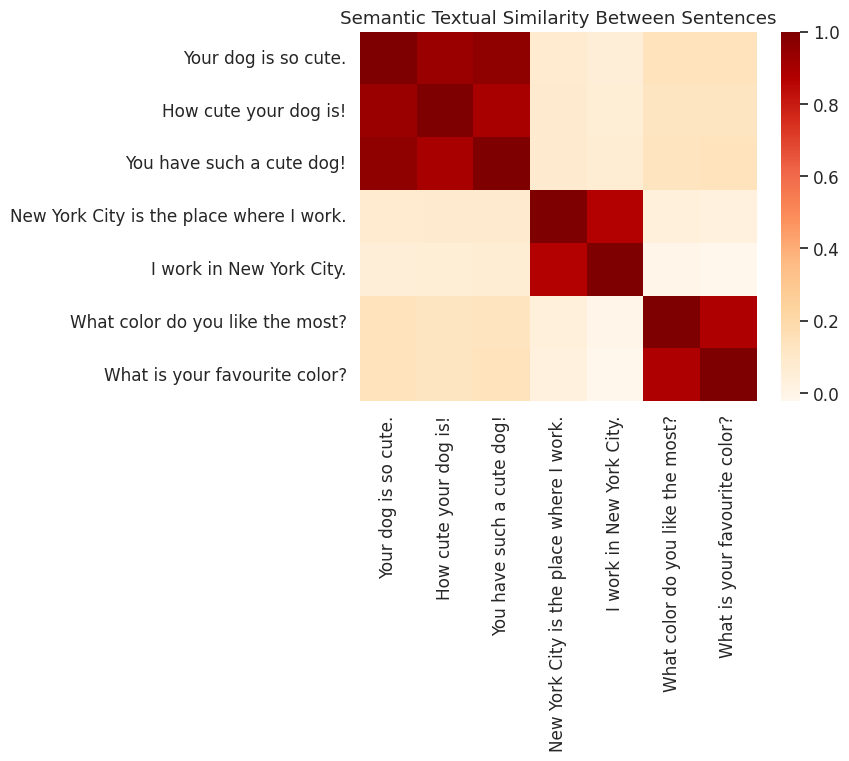

In [12]:
import sklearn
from sklearn.preprocessing import normalize
import numpy as np
import seaborn as sns


def plot_similarity_heatmap(text_labels, embeddings, rotation):
    """Takes sentences, embeddings and rotation as input and plot similarity heat map.

    Args:
      text_labels: a list of sentences to compute semantic textual similarity search.
      embeddings: a list of embedding vectors, each of which corresponds to a sentence.
      rotation: rotation used for display of the text_labels.
    """
    inner_product = np.inner(embeddings, embeddings)
    sns.set(font_scale=1.1)
    graph = sns.heatmap(
        inner_product,
        xticklabels=text_labels,
        yticklabels=text_labels,
        vmin=np.min(inner_product),
        vmax=1,
        cmap="OrRd",
    )
    graph.set_xticklabels(text_labels, rotation=rotation)
    graph.set_title("Semantic Textual Similarity Between Sentences")


sentences = [
    # Pets
    "Your dog is so cute.",
    "How cute your dog is!",
    "You have such a cute dog!",
    # Cities in the US
    "New York City is the place where I work.",
    "I work in New York City.",
    # Color
    "What color do you like the most?",
    "What is your favourite color?",
]

embeddings = []

for sentence in sentences:
    sentence = json.dumps({"inputText": sentence})
    query_response = get_embedding(body=sentence, modelId='amazon.titan-e1t-medium', accept='application/json', contentType='application/json')
    embeddings.append(query_response)
    
embeddings = normalize(np.array(embeddings), axis=1)  # normalization before inner product
plot_similarity_heatmap(sentences, embeddings, 90)